## Generating finalized neut curves for circulating strains
This notebook generates finalized plots for all serum validation neuts for circulating H3 HA strains (Figure S13). We also generate a dataframe of fold-change ICXX from the WT curve on each run, for analyzing correlation between DMS escape scores and neut assay results.

In [1]:
import pandas as pd

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import numpy as np

import matplotlib
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Get neut data from relevant runs for each serum

In [2]:
# make dict mapping serum to run:
serum_neuts = {
    '2388': ['240401_neuts-tidy', '240408_neuts-tidy'],
    '3862': ['240401_neuts-tidy', '240408_neuts-tidy'],
    '2380': ['240403_neuts-tidy-v2'],
    '199C': ['240408_neuts-tidy'],
}

# get data from relevant dfs for each serum
df_list = []
for serum in serum_neuts:
    i=0
    for filename in serum_neuts[serum]:
        df = pd.read_csv(f'neut_data/{filename}.csv')
        df['serum'] = df['serum'].astype(str)
        df = df[df['serum'] == serum]
        
        if i>0:
            df['serum'] = serum + '_2'
        
        df_list.append(df)
        
        i+=1

# get full df
full_neut_df = pd.concat(df_list)

# edit strain names
strain_dict = {
    'WT': 'WT',
    '4642_stockholm-14': 'A/Stockholm/18/2014',
    '4643_singapore-17': 'A/Singapore/TT0495/2017',
    '4644_ecuador-19': 'A/Ecuador/4472/2019', 
    '4645_south-auck-20': 'A/SouthAuckland/2/2020',
    '4646_zhejiang-22': 'A/Zhejiang-yongkang/1312/2022',
}

full_neut_df['virus'] = full_neut_df['virus'].map(strain_dict)

### Plot finalized neut curves
Generate a plot of neuts for all sera, using consistent color scheme with correlation scatterplots.

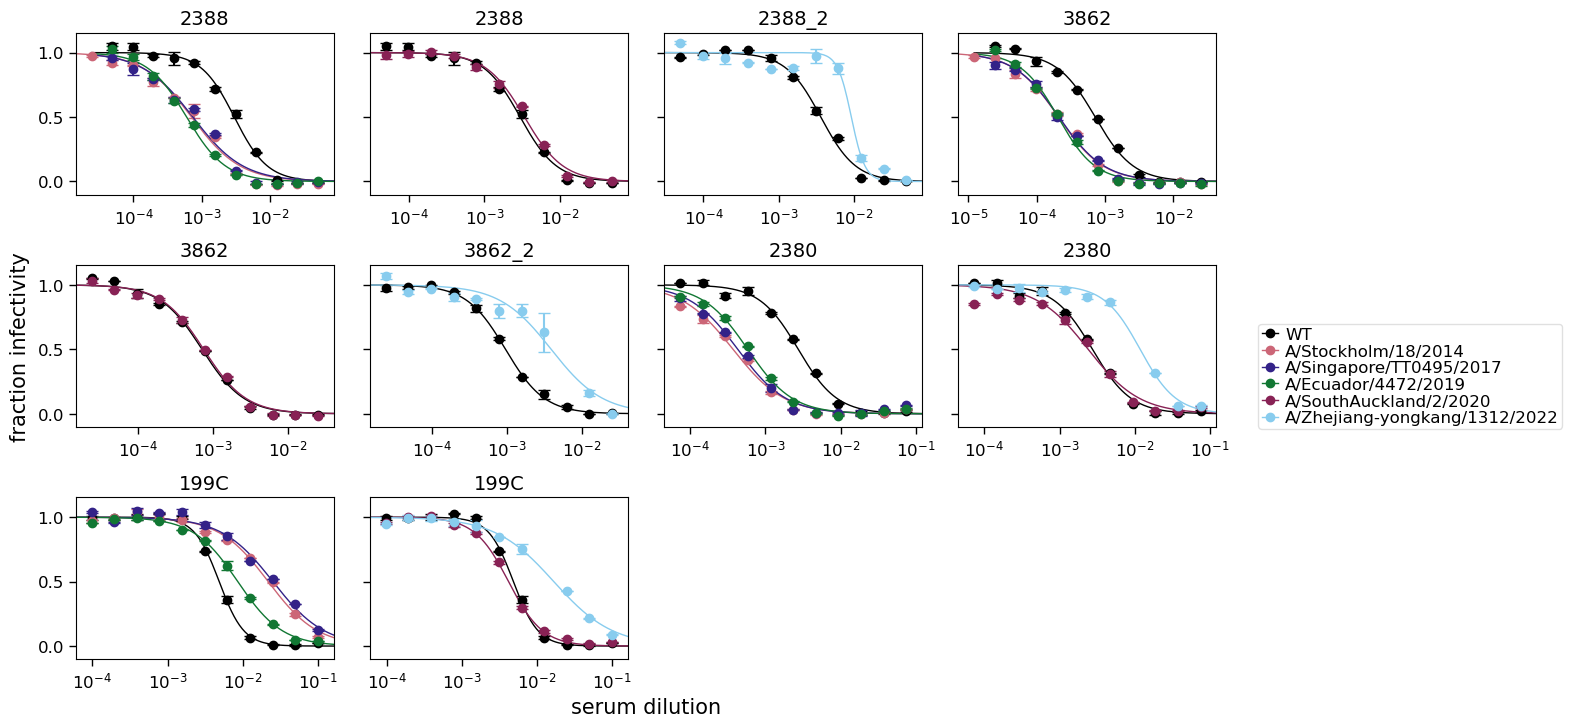

In [3]:
# order viruses for plotting
virus_order = ['WT',
               'A/Stockholm/18/2014', 
               'A/Singapore/TT0495/2017',
               'A/Ecuador/4472/2019', 
               'A/SouthAuckland/2/2020',
               'A/Zhejiang-yongkang/1312/2022',
              ]

full_neut_df['virus'] = pd.Categorical(full_neut_df.virus, categories=virus_order, ordered=True)
full_neut_df.sort_values('virus')

full_neut_df = full_neut_df.set_index('virus').loc[virus_order].reset_index()

# order sera for plotting
serum_order = ['2388', '2388_2', '3862', '3862_2', '2380', '199C']

full_neut_df['serum'] = pd.Categorical(full_neut_df.serum, categories=serum_order, ordered=True)
full_neut_df.sort_values('serum')

full_neut_df = full_neut_df.set_index('serum').loc[serum_order].reset_index()

# set custom colorscheme
virus_colors = {
    'WT': ['black', 'o'],
    'A/Stockholm/18/2014': ['#CC6677', 'o'],
    'A/Singapore/TT0495/2017': ['#332288', 'o'],
    'A/Ecuador/4472/2019': ['#117733', 'o'],
    'A/SouthAuckland/2/2020': ['#882255', 'o'],
    'A/Zhejiang-yongkang/1312/2022': ['#88CCEE', 'o'],
}

# fit with neutcurve package
fits = neutcurve.CurveFits(full_neut_df)

fig, axes = fits.plotSera(xlabel='serum dilution',
                          max_viruses_per_subplot=4,
                          sharex=False,
                          virus_to_color_marker=virus_colors
                         )

bbox = matplotlib.transforms.Bbox([[0, 0], [13, 10]])
plt.savefig('finalized_neut_curves_strains.pdf', bbox_inches=bbox)

### Calculate fold-change in ICXX for analysis of DMS correlations

In [4]:
def get_fold_changes(fits, ic):
    ic_df = fits.fitParams(ics=[ic])

    # Initialize an empty DataFrame to store the results
    fold_changes = pd.DataFrame()

    # Iterate through unique serum names
    for serum_name in ic_df['serum'].unique():
        # Filter data for the current serum
        serum_data = ic_df[ic_df['serum'] == serum_name]

        # Find the 'WT' ICX value for the current serum
        wt_ic = serum_data[serum_data['virus'] == 'WT'][f'ic{ic}'].values[0]

        # Filter out the 'WT' rows for the current serum
        # variant_data = serum_data[serum_data['virus'] != 'WT'].copy()
        variant_data = serum_data[serum_data['virus'] != 'WT'].copy()

        # Calculate log2 fold changes for the current serum
        variant_data[f'log2_fold_change_ic{ic}'] = np.log2(variant_data[f'ic{ic}'] / wt_ic)

        # Append the results to the fold_changes DataFrame
        fold_changes = pd.concat([fold_changes, variant_data[['serum', 'virus', f'log2_fold_change_ic{ic}', ]]])

    # Reset the index of the final DataFrame
    fold_changes = fold_changes.reset_index(drop=True)

    # Rename the 'virus' column to 'variant'
    fold_changes = fold_changes.rename(columns={'virus': 'variant'})
    
    # Remove '_2' from sera with 2 independent runs
    fold_changes['serum'] = fold_changes['serum'].str.replace('_2', '')
    
    return fold_changes

In [5]:
fold_changes = get_fold_changes(fits, 50)
    
fold_changes.to_csv(f'ic50_fold_changes_strains.csv', index=False)